In [103]:
import re
import random
import pandas as pd
import hashlib

In [104]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [105]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Azure Functions + PP365,107.742053,4.143925,26
SharePoint,247.571135,14.563008,17
Azure AI Search,409.875020,29.276787,14
Lost in a Good Book,651.510007,32.575500,20
Network Mapping,688.661551,32.793407,21
Python,693.881558,115.646926,6
Taxes,915.038414,91.503841,10
Finance Junk,1074.284844,134.285605,8
Search Engine Optimization,1249.137030,73.478649,17
Diffusers from Hugging Face,1258.101978,209.683663,6


# Histogram

40276.70


<Axes: >

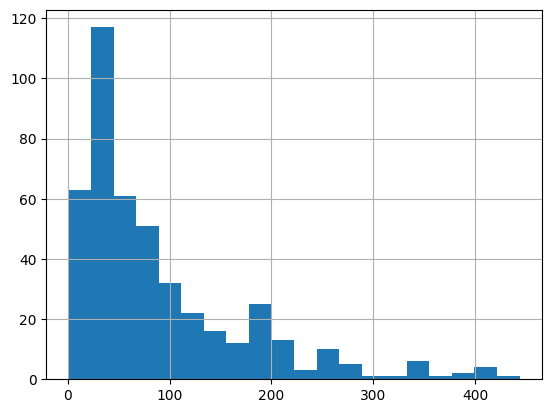

In [106]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [107]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [108]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [109]:
frequency = existing_cards['head'].value_counts(ascending=True)

existing_cards = pd.merge(
    left=existing_cards,
    right=frequency.rename('frequency'),
    left_on='head', right_index=True,
    how='left'
)
existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
existing_cards['age'] = existing_cards['age'] * -1


existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 446


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
153,Diffusers from Hugging Face,Text Encoder (CLIPTextModel): Also from transf...,565c03899fb065f93391be1cce005174,-443.778319,209.683663,-443.778319,1258.101978,0.958437,6,443.778319
305,Diffusers from Hugging Face,Scheduler (UniPCMultistepScheduler): A diffuse...,714e60b34b72275b331900cb0bb06083,-404.387607,209.683663,-443.778319,1258.101978,0.958437,6,443.778319
154,Diffusers from Hugging Face,"UNet (UNet2DConditionModel): In diffusers, UNe...",38e465bebcf1d5c08cd97ba9729fd451,-189.074154,209.683663,-443.778319,1258.101978,0.958437,6,443.778319
306,Diffusers from Hugging Face,Latent Space and Latent Noise: The initial noi...,d3bdb401f01ac680026547e02490991b,-121.414660,209.683663,-443.778319,1258.101978,0.958437,6,443.778319
155,Diffusers from Hugging Face,"Batch Size: In torch, batch size (len(prompt))...",027dbd3f7648b1365122572fb5805477,-57.303649,209.683663,-443.778319,1258.101978,0.958437,6,443.778319
307,Diffusers from Hugging Face,Guidance Scale: A float controlling adherence ...,229dc0119589dd8c362a2cee3640cc33,-42.143589,209.683663,-443.778319,1258.101978,0.958437,6,443.778319
81,Python,The print() function allows you to control the...,2fa67dd81ca813c197797f3dfe69aafc,-197.992920,115.646926,-197.992920,693.881558,0.010164,6,197.992920
234,Python,"In Python, special methods support comparison ...",fda018b0b93b0865cf1ada114d19a584,-181.074931,115.646926,-197.992920,693.881558,0.010164,6,197.992920
382,Python,"On UNIX-like systems, readline is part of Pyth...",f886c154eb8e437abefc15ad037e9a0c,-117.038103,115.646926,-197.992920,693.881558,0.010164,6,197.992920
82,Python,"If you invoke Response.raise_for_status(), the...",7b9415f877c5fcc40a358ae8ded54d73,-103.608110,115.646926,-197.992920,693.881558,0.010164,6,197.992920


# Focus on one header

In [110]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [111]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [112]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [113]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [114]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [115]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [116]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [117]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)


In [118]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
153,Diffusers from Hugging Face,Text Encoder (CLIPTextModel): Also from transf...,565c03899fb065f93391be1cce005174,-443.778319,209.683663,-443.778319,1258.101978,0.958437,6,443.778319
305,Diffusers from Hugging Face,Scheduler (UniPCMultistepScheduler): A diffuse...,714e60b34b72275b331900cb0bb06083,-404.387607,209.683663,-443.778319,1258.101978,0.958437,6,443.778319
154,Diffusers from Hugging Face,"UNet (UNet2DConditionModel): In diffusers, UNe...",38e465bebcf1d5c08cd97ba9729fd451,-189.074154,209.683663,-443.778319,1258.101978,0.958437,6,443.778319
306,Diffusers from Hugging Face,Latent Space and Latent Noise: The initial noi...,d3bdb401f01ac680026547e02490991b,-121.414660,209.683663,-443.778319,1258.101978,0.958437,6,443.778319
155,Diffusers from Hugging Face,"Batch Size: In torch, batch size (len(prompt))...",027dbd3f7648b1365122572fb5805477,-57.303649,209.683663,-443.778319,1258.101978,0.958437,6,443.778319
307,Diffusers from Hugging Face,Guidance Scale: A float controlling adherence ...,229dc0119589dd8c362a2cee3640cc33,-42.143589,209.683663,-443.778319,1258.101978,0.958437,6,443.778319
81,Python,The print() function allows you to control the...,2fa67dd81ca813c197797f3dfe69aafc,-197.992920,115.646926,-197.992920,693.881558,0.010164,6,197.992920
234,Python,"In Python, special methods support comparison ...",fda018b0b93b0865cf1ada114d19a584,-181.074931,115.646926,-197.992920,693.881558,0.010164,6,197.992920
382,Python,"On UNIX-like systems, readline is part of Pyth...",f886c154eb8e437abefc15ad037e9a0c,-117.038103,115.646926,-197.992920,693.881558,0.010164,6,197.992920
82,Python,"If you invoke Response.raise_for_status(), the...",7b9415f877c5fcc40a358ae8ded54d73,-103.608110,115.646926,-197.992920,693.881558,0.010164,6,197.992920


In [119]:
existing_cards.head(10)['age'].sum()

np.float64(-1857.8160417888819)